W210 EDA

In [ ]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Mount Google drive to look at data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_2020 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/run_ww_2020_d.parquet', engine='auto', columns=None, storage_options=None, use_nullable_dtypes=False)
df_2019 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/run_ww_2020_d.parquet', engine='auto', columns=None, storage_options=None, use_nullable_dtypes=False)

In [ ]:
# There are 0s for distance and duration if the athlete didn't train that day. Probably should leave these data points in

df_2020.head()

,datetime,athlete,distance,duration,gender,age_group,country,major
0,2020-01-01,0,0.00,0.000000,F,18 - 34,United States,CHICAGO 2019
1,2020-01-01,1,5.72,31.633333,M,35 - 54,Germany,BERLIN 2016
2,2020-01-01,2,0.00,0.000000,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2020-01-01,3,0.00,0.000000,M,18 - 34,United Kingdom,LONDON 2017
4,2020-01-01,4,8.07,38.616667,M,35 - 54,United States,BOSTON 2017


In [ ]:
# Get descriptive statistics for columns

df_2020.describe()

,athlete,distance,duration
count,1.332679e+07,1.332679e+07,1.332679e+07
mean,1.878141e+04,3.864718e+00,2.139198e+01
std,1.081663e+04,6.661547e+00,3.927359e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.428750e+03,0.000000e+00,0.000000e+00
50%,1.879250e+04,0.000000e+00,0.000000e+00
75%,2.810325e+04,7.070000e+00,3.993333e+01
max,3.759800e+04,3.479500e+02,2.299967e+03


In [ ]:
# Make sure index set to datetime
df_2020.set_index('datetime', inplace=True)

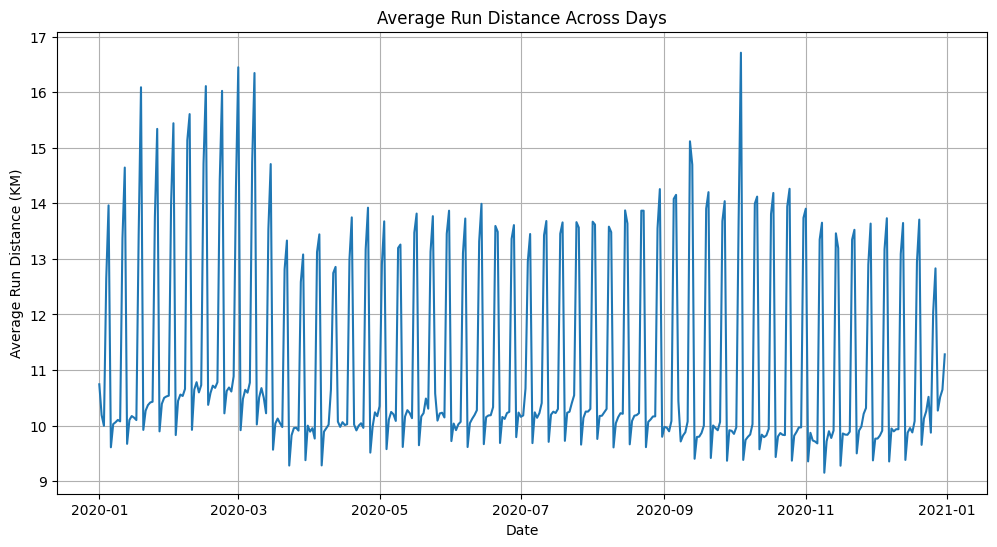

In [ ]:
# Build time series views of average distance across time
# Filtered out days where athletes rested

df_avg_distance = df_2020[df_2020['distance'] != 0]
#df_avg_distance = df['distance'].resample('D').mean()
df_avg_distance = df_avg_distance['distance'].resample('D').mean()

plt.figure(figsize=(12, 6))
plt.plot(df_avg_distance.index, df_avg_distance.values)
plt.title('Average Run Distance Across Days')
plt.xlabel('Date')
plt.ylabel('Average Run Distance (KM)')
plt.grid(True)
plt.show()

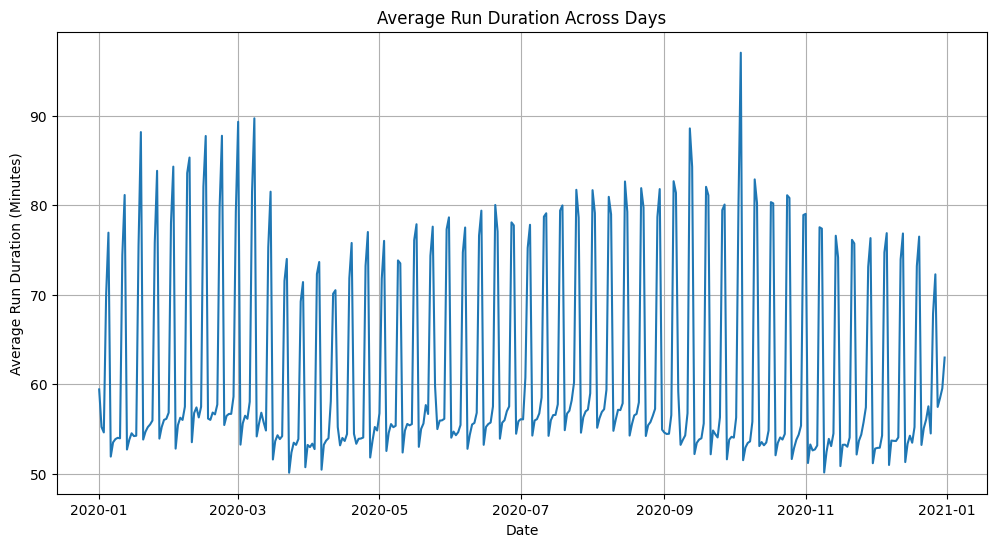

In [ ]:
# Average duration across time

df_avg_duration = df_2020[df_2020['duration'] != 0]
#df_avg_duration = df['duration'].resample('D').mean()
df_avg_duration = df_avg_duration['duration'].resample('D').mean()

plt.figure(figsize=(12, 6))
plt.plot(df_avg_duration.index, df_avg_duration.values)
plt.title('Average Run Duration Across Days')
plt.xlabel('Date')
plt.ylabel('Average Run Duration (Minutes)')
plt.grid(True)
plt.show()


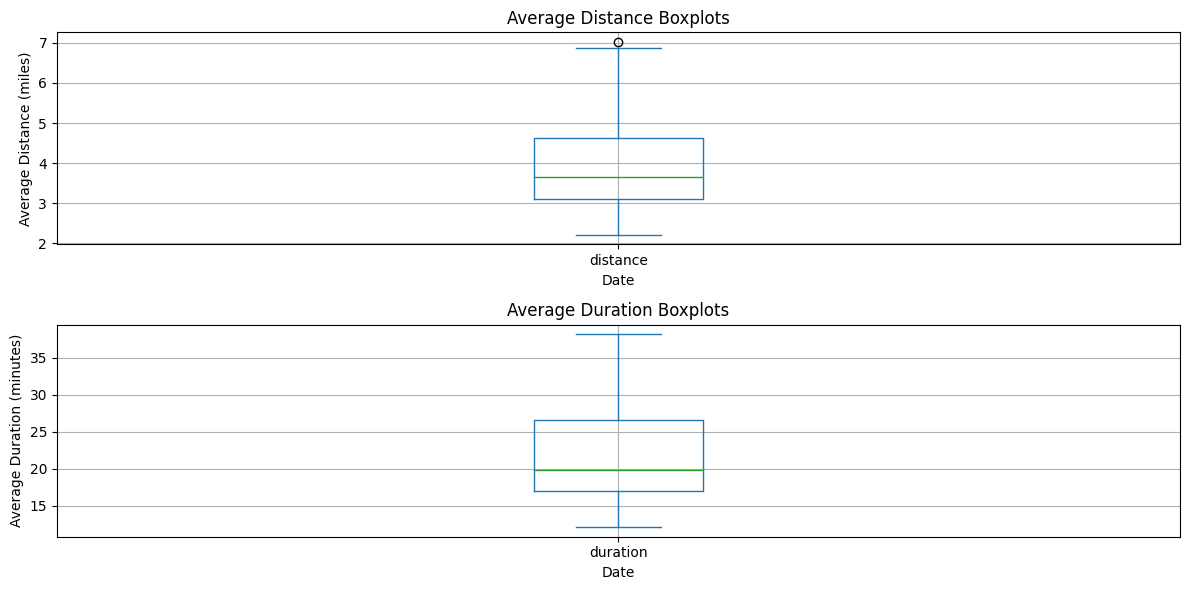

In [ ]:
# Boxplots for all days to see distribution of distance and duration

#df_runs_only = df[df['distance'] != 0]
#df_runs_only = df_runs_only[df_runs_only['duration'] != 0]
df_daily_avg = df_2020.groupby(df_2020.index.date).agg({'distance': 'mean', 'duration': 'mean'})

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
df_daily_avg['distance'].plot(kind='box')
plt.title('Average Distance Boxplots')
plt.xlabel('Date')
plt.ylabel('Average Distance (miles)')
plt.grid(True)

plt.subplot(2, 1, 2)
df_daily_avg['duration'].plot(kind='box')
plt.title('Average Duration Boxplots')
plt.xlabel('Date')
plt.ylabel('Average Duration (minutes)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#To Dos:

#Look at joining in biometrics from athletes / injury data based off of pace of training run / create synthetic data from Strava or use chatgpt

## Feature Engineering & Pace Vs. Distance

In [ ]:
# Get number of missing values

missing_values = df_2020.isnull().sum()
print(missing_values)

athlete           0
distance          0
duration          0
gender            0
age_group         0
country      120414
major             0
dtype: int64


In [ ]:
df_2020.head()

,athlete,distance,duration,gender,age_group,country,major
datetime,,,,,,,
2020-01-01,0,0.00,0.000000,F,18 - 34,United States,CHICAGO 2019
2020-01-01,1,5.72,31.633333,M,35 - 54,Germany,BERLIN 2016
2020-01-01,2,0.00,0.000000,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
2020-01-01,3,0.00,0.000000,M,18 - 34,United Kingdom,LONDON 2017
2020-01-01,4,8.07,38.616667,M,35 - 54,United States,BOSTON 2017


In [ ]:
# Define conversion function from integer minutes to minute timestamp
def pace_time_conversion(minutes):
  duration = pd.Timedelta(minutes=minutes)
  dummy_date = pd.to_datetime('2019-01-01')
  timestamp = dummy_date + duration
  formatted_timestamp = timestamp.strftime('%M:%S')
  return formatted_timestamp


In [ ]:
#Feature engineering for minutes per mile, days since last run by athlete, and average speed (miles per hour)

df_2019_runs_only = df_2019[df_2019['distance'] != 0]
df_2019_runs_only = df_2019_runs_only[df_2019_runs_only['duration'] != 0]
df_2019_runs_only['distance_miles'] = df_2019_runs_only['distance'] * 0.621371
df_2019_runs_only['speed_mph'] = (df_2019_runs_only['distance_miles']/df_2019_runs_only['duration']) * 60
df_2019_runs_only['pace'] = (df_2019_runs_only['duration']/df_2019_runs_only['distance_miles'])
#df_2019_runs_only['pace'] = (df_2019_runs_only['distance_miles']/df_2019_runs_only['duration']).apply(pace_time_conversion)



In [ ]:
# Get days since last run

# Sort the DataFrame by 'Athlete' and 'Date'
df_2019_runs_only = df_2019_runs_only.sort_values(['athlete', 'datetime'])

# Calculate the time difference in days since the last run for each athlete
df_2019_runs_only['Days_Since_Last_Run'] = df_2019_runs_only.groupby('athlete')['datetime'].diff().dt.days

# Fill missing values with 0 for the first run of each athlete
df_2019_runs_only['Days_Since_Last_Run'] = df_2019_runs_only['Days_Since_Last_Run'].fillna(0)

In [ ]:
df_2019_runs_only.head()

,datetime,athlete,distance,duration,gender,age_group,country,major,distance_miles,speed_mph,pace,Days_Since_Last_Run
1893424,2020-02-22,0,6.50,34.116667,F,18 - 34,United States,CHICAGO 2019,4.038912,7.103117,8.446995,0.0
2439604,2020-03-08,0,7.31,38.583333,F,18 - 34,United States,CHICAGO 2019,4.542222,7.063499,8.494374,15.0
2840136,2020-03-19,0,5.64,30.383333,F,18 - 34,United States,CHICAGO 2019,3.504532,6.920635,8.669725,11.0
2985784,2020-03-23,0,5.73,29.616667,F,18 - 34,United States,CHICAGO 2019,3.560456,7.213079,8.318223,4.0
3131432,2020-03-27,0,4.83,25.866667,F,18 - 34,United States,CHICAGO 2019,3.001222,6.961597,8.618712,4.0


In [ ]:
df_2019_runs_only.dtypes

datetime               datetime64[ns]
athlete                         int64
distance                      float64
duration                      float64
gender                         object
age_group                      object
country                        object
major                          object
distance_miles                float64
speed_mph                     float64
pace                          float64
Days_Since_Last_Run           float64
dtype: object

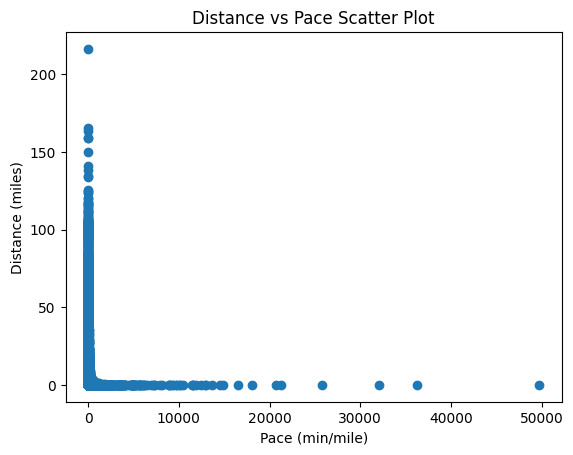

In [ ]:
plt.scatter(df_2019_runs_only['pace'], df_2019_runs_only['distance_miles'])

# Set the plot labels and title
plt.xlabel('Pace (min/mile)')
plt.ylabel('Distance (miles)')
plt.title('Distance vs Pace Scatter Plot')

# Display the plot
plt.show()

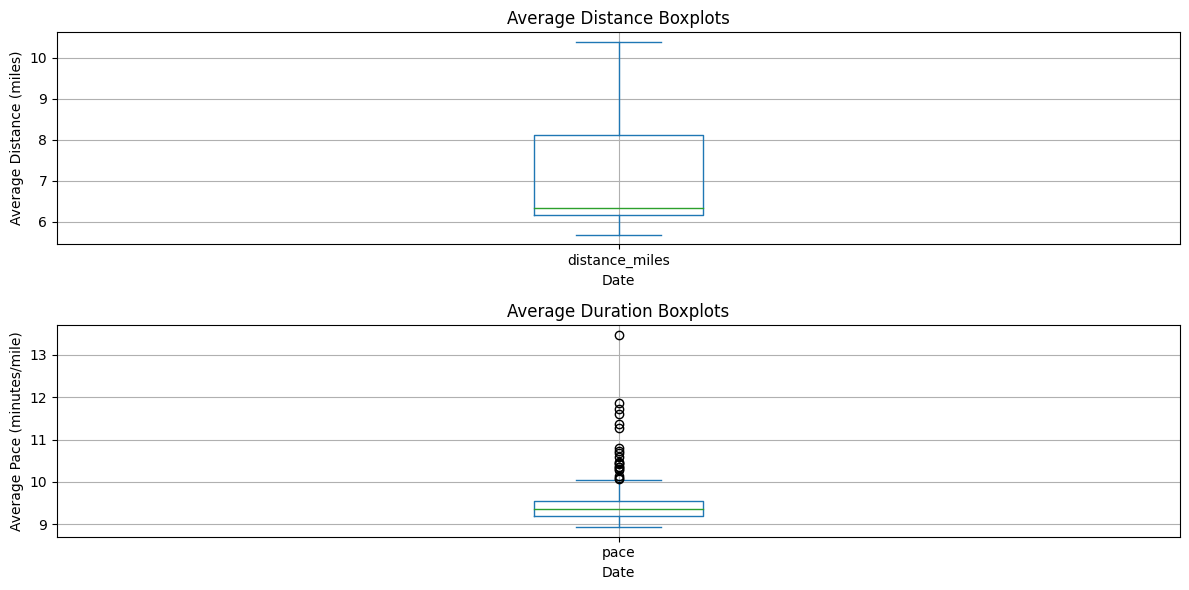

In [ ]:
#Check for outliers and exclude values at tail end

df_daily_avg = df_2019_runs_only.groupby(df_2019_runs_only.datetime).agg({'distance_miles': 'mean', 'pace': 'mean'})

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
df_daily_avg['distance_miles'].plot(kind='box')
plt.title('Average Distance Boxplots')
plt.xlabel('Date')
plt.ylabel('Average Distance (miles)')
plt.grid(True)

plt.subplot(2, 1, 2)
df_daily_avg['pace'].plot(kind='box')
plt.title('Average Duration Boxplots')
plt.xlabel('Date')
plt.ylabel('Average Pace (minutes/mile)')
plt.grid(True)

plt.tight_layout()
plt.show()

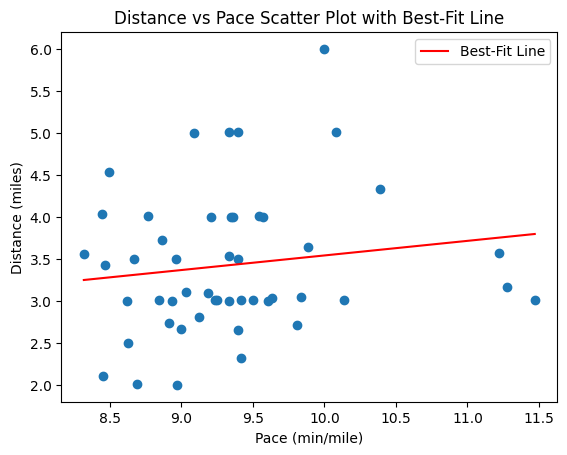

R-squared: 0.020735208392351545


In [ ]:
# Filter before using scatter; Need to work on
df_filtered = df_2019_runs_only[(df_2019_runs_only['pace'] <= 12.0) & (df_2019_runs_only['distance_miles'] <= 26) &(df_2019_runs_only['athlete'] == 0) ]

#plt.scatter(df_2019_runs_only[df_2019_runs_only['pace'] <= 10.0], df_2019_runs_only[df_2019_runs_only['distance_miles'] <= 10.5])
plt.scatter(df_filtered['pace'], df_filtered['distance_miles'])

# Set the plot labels and title
plt.xlabel('Pace (min/mile)')
plt.ylabel('Distance (miles)')
plt.title('Distance vs Pace Scatter Plot')

#
coefficients = np.polyfit(df_filtered['pace'], df_filtered['distance_miles'], deg=1)
slope = coefficients[0]
intercept = coefficients[1]

# Generate the x values for the line
x = np.linspace(df_filtered['pace'].min(), df_filtered['pace'].max(), 100)

# Calculate the corresponding y values using the line equation
y = slope * x + intercept

# Plot the best-fit line
plt.plot(x, y, color='red', label='Best-Fit Line')

# Set the plot labels and title
plt.xlabel('Pace (min/mile)')
plt.ylabel('Distance (miles)')
plt.title('Distance vs Pace Scatter Plot with Best-Fit Line')


# Calculate R-squared (R2)
residuals = df_filtered['distance_miles'] - (slope * df_filtered['pace'] + intercept)
ss_total = np.sum((df_filtered['distance_miles'] - df_filtered['distance_miles'].mean()) ** 2)
ss_residual = np.sum(residuals ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Add a legend
plt.legend()

# Display the plot
plt.show()

# Print R-squared (R2)
print("R-squared:", r_squared)

In [ ]:
# Filter before using scatter; Need to work on
'''
df_filtered = df_2019_runs_only[(df_2019_runs_only['pace'] <= 12.0) & (df_2019_runs_only['distance_miles'] <= 26) ]

#plt.scatter(df_2019_runs_only[df_2019_runs_only['pace'] <= 10.0], df_2019_runs_only[df_2019_runs_only['distance_miles'] <= 10.5])
plt.scatter(df_filtered['pace'], df_filtered['distance_miles'])

# Set the plot labels and title
plt.xlabel('Pace (min/mile)')
plt.ylabel('Distance (miles)')
plt.title('Distance vs Pace Scatter Plot')

#
coefficients = np.polyfit(df_filtered['pace'], df_filtered['distance_miles'], deg=1)
slope = coefficients[0]
intercept = coefficients[1]

# Generate the x values for the line
x = np.linspace(df_filtered['pace'].min(), df_filtered['pace'].max(), 100)

# Calculate the corresponding y values using the line equation
y = slope * x + intercept

# Plot the best-fit line
plt.plot(x, y, color='red', label='Best-Fit Line')

# Set the plot labels and title
plt.xlabel('Pace (min/mile)')
plt.ylabel('Distance (miles)')
plt.title('Distance vs Pace Scatter Plot with Best-Fit Line')


# Calculate R-squared (R2)
residuals = df_filtered['distance_miles'] - (slope * df_filtered['pace'] + intercept)
ss_total = np.sum((df_filtered['distance_miles'] - df_filtered['distance_miles'].mean()) ** 2)
ss_residual = np.sum(residuals ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Add a legend
plt.legend()

# Display the plot
plt.show()

# Print R-squared (R2)
print("R-squared:", r_squared)
'''

'\ndf_filtered = df_2019_runs_only[(df_2019_runs_only[\'pace\'] <= 12.0) & (df_2019_runs_only[\'distance_miles\'] <= 26) ]\n\n#plt.scatter(df_2019_runs_only[df_2019_runs_only[\'pace\'] <= 10.0], df_2019_runs_only[df_2019_runs_only[\'distance_miles\'] <= 10.5])\nplt.scatter(df_filtered[\'pace\'], df_filtered[\'distance_miles\'])\n\n# Set the plot labels and title\nplt.xlabel(\'Pace (min/mile)\')\nplt.ylabel(\'Distance (miles)\')\nplt.title(\'Distance vs Pace Scatter Plot\')\n\n#\ncoefficients = np.polyfit(df_filtered[\'pace\'], df_filtered[\'distance_miles\'], deg=1)\nslope = coefficients[0]\nintercept = coefficients[1]\n\n# Generate the x values for the line\nx = np.linspace(df_filtered[\'pace\'].min(), df_filtered[\'pace\'].max(), 100)\n\n# Calculate the corresponding y values using the line equation\ny = slope * x + intercept\n\n# Plot the best-fit line\nplt.plot(x, y, color=\'red\', label=\'Best-Fit Line\')\n\n# Set the plot labels and title\nplt.xlabel(\'Pace (min/mile)\')\nplt.yla

In [ ]:
df_2019_runs_only.head()

,datetime,athlete,distance,duration,gender,age_group,country,major,distance_miles,speed_mph,pace,Days_Since_Last_Run
1893424,2020-02-22,0,6.50,34.116667,F,18 - 34,United States,CHICAGO 2019,4.038912,7.103117,8.446995,0.0
2439604,2020-03-08,0,7.31,38.583333,F,18 - 34,United States,CHICAGO 2019,4.542222,7.063499,8.494374,15.0
2840136,2020-03-19,0,5.64,30.383333,F,18 - 34,United States,CHICAGO 2019,3.504532,6.920635,8.669725,11.0
2985784,2020-03-23,0,5.73,29.616667,F,18 - 34,United States,CHICAGO 2019,3.560456,7.213079,8.318223,4.0
3131432,2020-03-27,0,4.83,25.866667,F,18 - 34,United States,CHICAGO 2019,3.001222,6.961597,8.618712,4.0


In [ ]:
# Remove outliers for distance and pace
df_vf = df_2019_runs_only[(df_2019_runs_only['pace'] <= 12.0) & (df_2019_runs_only['distance_miles'] <= 26)]

In [ ]:
df_vf.head()

,datetime,athlete,distance,duration,gender,age_group,country,major,distance_miles,speed_mph,pace,Days_Since_Last_Run
1893424,2020-02-22,0,6.50,34.116667,F,18 - 34,United States,CHICAGO 2019,4.038912,7.103117,8.446995,0.0
2439604,2020-03-08,0,7.31,38.583333,F,18 - 34,United States,CHICAGO 2019,4.542222,7.063499,8.494374,15.0
2840136,2020-03-19,0,5.64,30.383333,F,18 - 34,United States,CHICAGO 2019,3.504532,6.920635,8.669725,11.0
2985784,2020-03-23,0,5.73,29.616667,F,18 - 34,United States,CHICAGO 2019,3.560456,7.213079,8.318223,4.0
3131432,2020-03-27,0,4.83,25.866667,F,18 - 34,United States,CHICAGO 2019,3.001222,6.961597,8.618712,4.0


In [ ]:
# get average and max pace for intensity by pace
df_vf['individual_average_pace'] = df_vf.groupby('athlete')['pace'].transform('mean')
df_vf['individual_min_pace'] = df_vf.groupby('athlete')['pace'].transform('min')
df_vf['individual_average_distance'] = df_vf.groupby('athlete')['distance_miles'].transform('mean')
df_vf['individual_max_distance'] = df_vf.groupby('athlete')['distance_miles'].transform('max')


<ipython-input-25-c631d5691d92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vf['individual_average_pace'] = df_vf.groupby('athlete')['pace'].transform('mean')
<ipython-input-25-c631d5691d92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vf['individual_min_pace'] = df_vf.groupby('athlete')['pace'].transform('min')
<ipython-input-25-c631d5691d92>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [ ]:
df_vf.head()

,datetime,athlete,distance,duration,gender,age_group,country,major,distance_miles,speed_mph,pace,Days_Since_Last_Run,individual_average_pace,individual_min_pace,individual_average_distance,individual_max_distance
1893424,2020-02-22,0,6.50,34.116667,F,18 - 34,United States,CHICAGO 2019,4.038912,7.103117,8.446995,0.0,9.343666,8.318223,3.4287,6.002444
2439604,2020-03-08,0,7.31,38.583333,F,18 - 34,United States,CHICAGO 2019,4.542222,7.063499,8.494374,15.0,9.343666,8.318223,3.4287,6.002444
2840136,2020-03-19,0,5.64,30.383333,F,18 - 34,United States,CHICAGO 2019,3.504532,6.920635,8.669725,11.0,9.343666,8.318223,3.4287,6.002444
2985784,2020-03-23,0,5.73,29.616667,F,18 - 34,United States,CHICAGO 2019,3.560456,7.213079,8.318223,4.0,9.343666,8.318223,3.4287,6.002444
3131432,2020-03-27,0,4.83,25.866667,F,18 - 34,United States,CHICAGO 2019,3.001222,6.961597,8.618712,4.0,9.343666,8.318223,3.4287,6.002444


In [ ]:
# create intensity function
'''
def calculate_intensity(training_run_pace, fastest_pace, distance):
    """
    Calculate the intensity score of a training run based on the average pace and distance.
    Scale the intensity score to a range of 1-10.

    Parameters:
    average_pace (float): Average pace of the training run in seconds per kilometer.
    fastest_pace (float): Fastest pace ever achieved by the runner in seconds per kilometer.
    distance (float): Distance of the training run in kilometers.

    Returns:
    float: Scaled intensity score of the training run.
    """
    intensity = fastest_pace / training_run_pace #training_run_pace / fastest_pace
    intensity *= distance

    # Scale the intensity score to a range of 1-10
    scaled_intensity = (intensity - 1) * 9 / (fastest_pace / distance - 1) + 1

    return scaled_intensity
    '''

# Maybe look at best fit line too and then take 20% above and below
def compute_relative_effort(run_pace, average_pace, distance, average_distance):
    # Calculate the effort score
    pace_multiplier = average_pace / run_pace
    distance_multiplier = distance / average_distance
    effort = 5 * pace_multiplier * distance_multiplier
    effort = np.clip(effort, 1, 10)

    return round(effort)

# Clip values above 10 and lower than 1
def clip_intensity(effort):
  # Set ceiling and floor for the effort level
  ceiling = 10  # Maximum effort level
  floor = 1     # Minimum effort level

  # Apply ceiling and floor constraints
  effort = np.clip(effort, floor, ceiling)

  return(effort)


In [ ]:
df_vf['intensity'] = df_vf.groupby('athlete').apply(lambda x: compute_relative_effort(x['pace'], x['individual_average_pace'], x['distance_miles'], x['individual_average_distance'])).reset_index(drop=True)
#df_vf['intensity'] = df_vf.groupby('athlete')['pace'].transform(lambda x: compute_relative_effort(x, x.mean(), df_vf['distance_miles'], df_vf['individual_average_distance']))

<ipython-input-28-1b61214e0a06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vf['intensity'] = df_vf.groupby('athlete').apply(lambda x: compute_relative_effort(x['pace'], x['individual_average_pace'], x['distance_miles'], x['individual_average_distance'])).reset_index(drop=True)


In [ ]:
#df_vf['intensity'] = df_vf.groupby('athlete').apply(lambda x: clip_intensity(x['intensity'])).reset_index(drop=True)
#df_vf['intensity'] = df_vf.groupby('athlete')['pace'].transform(lambda x: compute_relative_effort(x, x.mean(), df_vf['distance_miles'], df_vf['individual_average_distance']))


In [ ]:
df_vf.head(10)

,datetime,athlete,distance,duration,gender,age_group,country,major,distance_miles,speed_mph,pace,Days_Since_Last_Run,individual_average_pace,individual_min_pace,individual_average_distance,individual_max_distance,intensity
1893424,2020-02-22,0,6.50,34.116667,F,18 - 34,United States,CHICAGO 2019,4.038912,7.103117,8.446995,0.0,9.343666,8.318223,3.4287,6.002444,5.0
2439604,2020-03-08,0,7.31,38.583333,F,18 - 34,United States,CHICAGO 2019,4.542222,7.063499,8.494374,15.0,9.343666,8.318223,3.4287,6.002444,6.0
2840136,2020-03-19,0,5.64,30.383333,F,18 - 34,United States,CHICAGO 2019,3.504532,6.920635,8.669725,11.0,9.343666,8.318223,3.4287,6.002444,4.0
2985784,2020-03-23,0,5.73,29.616667,F,18 - 34,United States,CHICAGO 2019,3.560456,7.213079,8.318223,4.0,9.343666,8.318223,3.4287,6.002444,10.0
3131432,2020-03-27,0,4.83,25.866667,F,18 - 34,United States,CHICAGO 2019,3.001222,6.961597,8.618712,4.0,9.343666,8.318223,3.4287,6.002444,7.0
3240668,2020-03-30,0,4.03,21.600000,F,18 - 34,United States,CHICAGO 2019,2.504125,6.955903,8.625767,3.0,9.343666,8.318223,3.4287,6.002444,5.0
3313492,2020-04-01,0,3.39,17.800000,F,18 - 34,United States,CHICAGO 2019,2.106448,7.100385,8.450245,2.0,9.343666,8.318223,3.4287,6.002444,4.0
3459140,2020-04-05,0,6.45,35.133333,F,18 - 34,United States,CHICAGO 2019,4.007843,6.844514,8.766145,4.0,9.343666,8.318223,3.4287,6.002444,4.0
3531964,2020-04-07,0,5.52,29.033333,F,18 - 34,United States,CHICAGO 2019,3.429968,7.088338,8.464608,2.0,9.343666,8.318223,3.4287,6.002444,10.0
4005320,2020-04-20,0,8.06,47.050000,F,18 - 34,United States,CHICAGO 2019,5.008250,6.386717,9.394499,13.0,9.343666,8.318223,3.4287,6.002444,3.0


In [ ]:
'''grouped_df = df_vf.groupby('athlete')['intensity']

# Create a list of intensity values for each athlete
data = [grouped_df.get_group(athlete) for athlete in df_vf['athlete'].unique()]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=df_vf['athlete'].unique())
plt.title('Intensity Boxplots by Athlete')
plt.xlabel('Athlete')
plt.ylabel('Intensity')
plt.show()
'''

"grouped_df = df_vf.groupby('athlete')['intensity']\n\n# Create a list of intensity values for each athlete\ndata = [grouped_df.get_group(athlete) for athlete in df_vf['athlete'].unique()]\n\n# Create the boxplot\nplt.figure(figsize=(10, 6))\nplt.boxplot(data, labels=df_vf['athlete'].unique())\nplt.title('Intensity Boxplots by Athlete')\nplt.xlabel('Athlete')\nplt.ylabel('Intensity')\nplt.show()\n"

In [ ]:
#get average intensity of all athletes
average_intensity = df_vf.groupby('athlete')['intensity'].mean()
print(average_intensity)

athlete
0        6.000000
1        4.879310
2        5.133333
3        4.966667
4        4.956522
           ...   
37594    4.785047
37595    5.132075
37596    4.769231
37597    5.185185
37598    5.118644
Name: intensity, Length: 34735, dtype: float64


In [ ]:
#df_vf_filtered = df_vf[(df_vf['athlete'] >= 0) & (df_vf['athlete'] <= 1000)]
df_vf_filtered = df_vf[(df_vf['athlete'] == 3)]

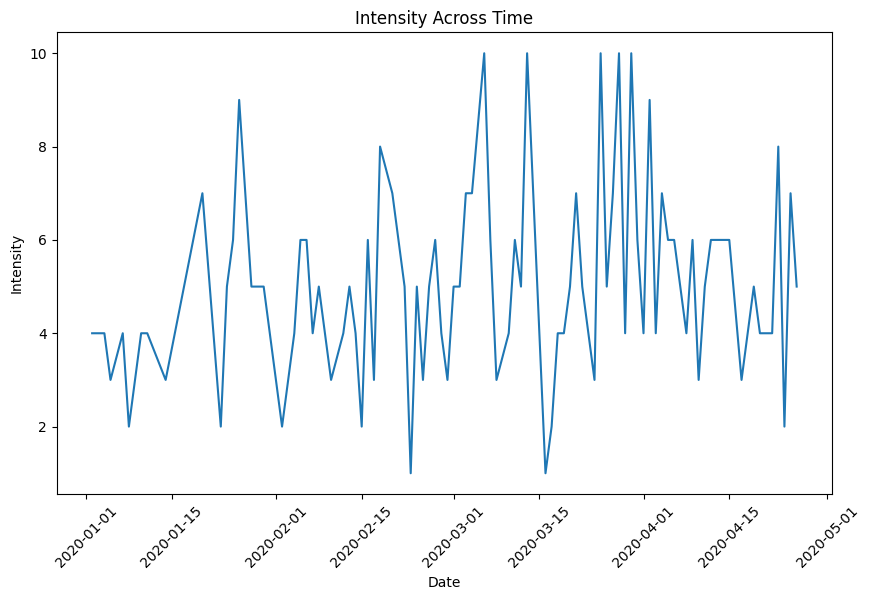

In [ ]:
# Create the boxplot
plt.figure(figsize=(10, 6))
plt.plot(df_vf_filtered['datetime'], df_vf_filtered['intensity'])
plt.title('Intensity Across Time')
plt.xlabel('Date')
plt.ylabel('Intensity')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#import numpy as np

# Group the DataFrame by athlete
grouped_df = df_vf.groupby('athlete')

# Calculate the slope for each athlete
slopes = []
for _, group in grouped_df:
    pace = group['pace']
    distance = group['distance_miles']
    slope, _ = np.polyfit(distance, pace, deg=1)
    slopes.append(slope)

# Create a new column for the slope in the original DataFrame
df_vf['slope'] = np.repeat(slopes, grouped_df.size().values)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: RankWarning: Polyfit may be poo

In [ ]:
df_vf.head()

,datetime,athlete,distance,duration,gender,age_group,country,major,distance_miles,speed_mph,pace,Days_Since_Last_Run,individual_average_pace,individual_min_pace,individual_average_distance,individual_max_distance,intensity,slope
1893424,2020-02-22,0,6.50,34.116667,F,18 - 34,United States,CHICAGO 2019,4.038912,7.103117,8.446995,0.0,9.343666,8.318223,3.4287,6.002444,5.0,0.119273
2439604,2020-03-08,0,7.31,38.583333,F,18 - 34,United States,CHICAGO 2019,4.542222,7.063499,8.494374,15.0,9.343666,8.318223,3.4287,6.002444,6.0,0.119273
2840136,2020-03-19,0,5.64,30.383333,F,18 - 34,United States,CHICAGO 2019,3.504532,6.920635,8.669725,11.0,9.343666,8.318223,3.4287,6.002444,4.0,0.119273
2985784,2020-03-23,0,5.73,29.616667,F,18 - 34,United States,CHICAGO 2019,3.560456,7.213079,8.318223,4.0,9.343666,8.318223,3.4287,6.002444,10.0,0.119273
3131432,2020-03-27,0,4.83,25.866667,F,18 - 34,United States,CHICAGO 2019,3.001222,6.961597,8.618712,4.0,9.343666,8.318223,3.4287,6.002444,7.0,0.119273
